## Import Libraries

In [1]:
import os
import cv2
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.svm import SVC
from skimage.feature import hog
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import train_test_split

## Make file txt

In [2]:
dd=os.listdir('TIN')
f1 = open('00_all.txt', 'w')
for i in range(len(dd)):
    d2 = os.listdir ('TIN/%s/images/'%(dd[i]))
    for j in range(len(d2)):
        str1='TIN/%s/images/%s'%(dd[i], d2[j])
        f1.write("%s %d\n" % (str1, i))
f1.close()

## Feature extraction

In [3]:
## color histogram
def color_histogram(image, mask=None):
    hist = cv2.calcHist([image], [0, 1, 2], mask, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

## HOG
def hog_feature(image):
    hog_features, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)
    return hog_features.flatten()

## SURF
def sift_feature(image, th=5):
    sift = cv2.SIFT_create(th)
    kp, des = sift.detectAndCompute(image, None)
    return des
# resouces: https://github.com/Akhilesh64/Image-Classification-using-SIFT
def bag_of_features(features, centres, k = 128):
    vec = np.zeros((1, k))
    for i in range(features.shape[0]):
        feat = features[i]
        diff = np.tile(feat, (k, 1)) - centres
        dist = pow(((pow(diff, 2)).sum(axis = 1)), 0.5)
        idx_dist = dist.argsort()
        idx = idx_dist[0]
        vec[0][idx] += 1
    return vec

## Load Data (General)

In [4]:
def load_img(f, feat=None):
    f=open(f)
    lines=f.readlines()
    imgs, desc, labs=[], [], []
    for i in range(len(lines)):
        fn, label = lines[i].split(' ')
        
        im1=cv2.imread(fn)
        im1=cv2.resize(im1, (256,256))
        
        # Important!!! Implementation and justification of feature extraction methods (40%)

        if feat == "color_histogram":
            vec = color_histogram(im1)
            imgs.append(vec)
        elif feat == "hog_feature":
            im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
            vec = hog_feature(im1)
            imgs.append(vec)
        elif feat == "sift_feature":
            im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
            img_des = sift_feature(im1)
            if img_des is not None:
                desc.append(img_des)
        else:
            imgs.append(im1.flatten())
        labs.append(int(label))
    
    if feat == "sift_feature":
        desc = np.vstack(desc)
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.1)
        flags = cv2.KMEANS_RANDOM_CENTERS
        compactness, labels, centres = cv2.kmeans(desc, 128, None, criteria, 10, flags)

        for i in range(len(lines)):
            fn, label = lines[i].split(' ')
            
            im1=cv2.imread(fn)
            im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
            img_des = sift_feature(im1)
            if img_des is not None:
                img_vec = bag_of_features(img_des, centres)
                imgs.append(img_vec)
            else:
                imgs.append(np.zeros((1, 128)))
        imgs = np.vstack(imgs)
        
    imgs= np.asarray(imgs, np.float32)
    labs= np.asarray(labs, np.int32)
    return imgs, labs

## KNN [Implementation of classification models 1 (40%)]

In [5]:
X, y = load_img('02_bit.txt', feat=None)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [6]:
# 創建 KNN 分類器
knn = KNeighborsClassifier()

# 訓練模型
knn.fit(X_train,y_train)

# 預測
y_pred = knn.predict(X_temp)

# 計算 F1 分數
print('KNN F1 Score: %.3f' % f1_score(y_temp,y_pred,average='weighted'))
# 計算準確度
print('KNN Accuracy: %.3f' % accuracy_score(y_temp,y_pred))

KNN F1 Score: 0.601
KNN Accuracy: 0.635


### color histogram [Implementation and justification of feature extraction methods 1 (40%)]

In [7]:
X, y = load_img('02_bit.txt', feat="color_histogram")
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [8]:
# 創建 KNN 分類器
knn = KNeighborsClassifier()

# 訓練模型
knn.fit(X_train,y_train)

# 預測
y_pred = knn.predict(X_temp)

# 計算 F1 分數
print('KNN + Color Histogram - F1 Score: %.3f' % f1_score(y_temp,y_pred,average='weighted'))
# 計算準確度
print('KNN + Color Histogram - Accuracy: %.3f' % accuracy_score(y_temp,y_pred))

KNN + Color Histogram - F1 Score: 0.793
KNN + Color Histogram - Accuracy: 0.800


### HOG [Implementation and justification of feature extraction methods 2 (40%)]

In [9]:
X, y = load_img('02_bit.txt', feat="hog_feature")
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [10]:
# 創建 KNN 分類器
knn = KNeighborsClassifier()

# 訓練模型
knn.fit(X_train,y_train)

# 預測
y_pred = knn.predict(X_temp)

# 計算 F1 分數
print('KNN + Hog - F1 Score: %.3f' % f1_score(y_temp,y_pred,average='weighted'))
# 計算準確度
print('KNN + Hog - Accuracy: %.3f' % accuracy_score(y_temp,y_pred))

KNN + Hog - F1 Score: 0.495
KNN + Hog - Accuracy: 0.590


### SIFT [Implementation and justification of feature extraction methods 3 (40%)]

In [11]:
X, y = load_img('02_bit.txt', feat="sift_feature")
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [12]:
# 創建 KNN 分類器
knn = KNeighborsClassifier()

# 訓練模型
knn.fit(X_train,y_train)

# 預測
y_pred = knn.predict(X_temp)

# 計算 F1 分數
print('KNN + SIFT - F1 Score: %.3f' % f1_score(y_temp,y_pred,average='weighted'))
# 計算準確度
print('KNN + SIFT - Accuracy: %.3f' % accuracy_score(y_temp,y_pred))

KNN + SIFT - F1 Score: 0.635
KNN + SIFT - Accuracy: 0.645


## SVM [Implementation of classification models 2 (40%)]

In [13]:
X, y = load_img('02_bit.txt', feat=None)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [14]:
# 創建 SVM 分類器
svc = SVC(kernel='linear',gamma='auto')

# 訓練模型
svc.fit(X_train, y_train)

# 預測
y_pred = svc.predict(X_temp)

# 計算 F1 分數
print('KNN F1 Score: %.3f' % f1_score(y_temp,y_pred,average='weighted'))
# 計算準確度
print('KNN Accuracy: %.3f' % accuracy_score(y_temp,y_pred))

KNN F1 Score: 0.799
KNN Accuracy: 0.800


### color histogram [Implementation and justification of feature extraction methods 1 (40%)]

In [15]:
X, y = load_img('02_bit.txt', feat="color_histogram")
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [16]:
# 創建 SVM 分類器
svc = SVC(kernel='linear',gamma='auto')

# 訓練模型
svc.fit(X_train, y_train)

# 預測
y_pred = svc.predict(X_temp)

# 計算 F1 分數
print('SVM + Color Histogram - F1 Score: %.3f' % f1_score(y_temp,y_pred,average='weighted'))
# 計算準確度
print('SVM + Color Histogram - Accuracy: %.3f' % accuracy_score(y_temp,y_pred))

SVM + Color Histogram - F1 Score: 0.869
SVM + Color Histogram - Accuracy: 0.870


### HOG [Implementation and justification of feature extraction methods 2 (40%)]

In [17]:
X, y = load_img('02_bit.txt', feat="hog_feature")
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [18]:
# 創建 SVM 分類器
svc = SVC(kernel='linear',gamma='auto')

# 訓練模型
svc.fit(X_train, y_train)

# 預測
y_pred = svc.predict(X_temp)

# 計算 F1 分數
print('SVM + Hog - F1 Score: %.3f' % f1_score(y_temp,y_pred,average='weighted'))
# 計算準確度
print('SVM + Hog - Accuracy: %.3f' % accuracy_score(y_temp,y_pred))

SVM + Hog - F1 Score: 0.810
SVM + Hog - Accuracy: 0.810


### SIFT [Implementation and justification of feature extraction methods 3 (40%)]

In [19]:
X, y = load_img('02_bit.txt', feat="sift_feature")
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [20]:
# 創建 SVM 分類器
svc = SVC(kernel='linear',gamma='auto')

# 訓練模型
svc.fit(X_train, y_train)

# 預測
y_pred = svc.predict(X_temp)

# 計算 F1 分數
print('SVM + SIFT - F1 Score: %.3f' % f1_score(y_temp,y_pred,average='weighted'))
# 計算準確度
print('SVM + SIFT - Accuracy: %.3f' % accuracy_score(y_temp,y_pred))

SVM + SIFT - F1 Score: 0.744
SVM + SIFT - Accuracy: 0.745


## Load Data (Pytorch)

In [21]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class dataset(Dataset):
    def __init__(self, txt_file, transform=None):
        self.data = pd.read_csv(txt_file, sep=" ", header=None)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        image = Image.open(img_name)
        label = self.data.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

In [22]:
fullset = dataset(txt_file='02_bit.txt', transform=transform)
trainset, valset, testset = random_split(fullset, [0.8, 0.1, 0.1], generator=torch.Generator().manual_seed(42))

trainloader = DataLoader(trainset, batch_size=100, shuffle=True, num_workers=0)
valloader = DataLoader(valset, batch_size=100, shuffle=False, num_workers=0)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=0)

## Swin Transformer

In [23]:
class Swin(nn.Module):
    def __init__(self):
        super(Swin, self).__init__()
        self.model = models.swin_v2_b()
        self.model.head = nn.Linear(1024, 2)

    def forward(self, x):
        return self.model(x)

model = Swin()

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [25]:
# torch.cuda.empty_cache()

In [26]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

Swin(
  (model): SwinTransformer(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
        (1): Permute()
        (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (1): Sequential(
        (0): SwinTransformerBlockV2(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): ShiftedWindowAttentionV2(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (proj): Linear(in_features=128, out_features=128, bias=True)
            (cpb_mlp): Sequential(
              (0): Linear(in_features=2, out_features=512, bias=True)
              (1): ReLU(inplace=True)
              (2): Linear(in_features=512, out_features=4, bias=False)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): MLP(
            (0): Linear(in_feature

## Swin Transformer with Transfer Learning [Implementation of classification models 3 (40%)]

In [27]:
for epoch in range(10):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0
    f1 = 0.0

    progress_bar = tqdm(enumerate(trainloader), total=len(trainloader))
    for i, data in progress_bar:
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        f1 += f1_score(labels.cpu(), predicted.cpu(), average='macro')

        progress_bar.set_description(f'Epoch {epoch+1}, Training: Loss: {running_loss / (i+1):.4f}, Accuracy: {100.*correct/total:.2f}%, F1 Score: {f1 / (i+1):.3f}')

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_f1 = 0.0

    with torch.no_grad():
        for data in valloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
            val_f1 += f1_score(labels.cpu(), predicted.cpu(), average='macro')

    print(f'Validation: Loss: {val_loss / len(valloader):.3f}, Accuracy: {100.*val_correct/val_total:.2f}%, F1 Score: {val_f1 / len(valloader):.3f}')

print('Finished Training')

Epoch 1, Training: Loss: 0.7148, Accuracy: 54.75%, F1 Score: 0.530: 100%|██████████| 8/8 [07:39<00:00, 57.42s/it]


Validation: Loss: 0.608, Accuracy: 68.00%, F1 Score: 0.680


Epoch 2, Training: Loss: 0.5028, Accuracy: 75.12%, F1 Score: 0.747: 100%|██████████| 8/8 [07:14<00:00, 54.37s/it]


Validation: Loss: 0.517, Accuracy: 84.00%, F1 Score: 0.833


Epoch 3, Training: Loss: 0.3850, Accuracy: 83.75%, F1 Score: 0.832: 100%|██████████| 8/8 [07:17<00:00, 54.69s/it]


Validation: Loss: 0.489, Accuracy: 90.00%, F1 Score: 0.894


Epoch 4, Training: Loss: 0.3276, Accuracy: 85.62%, F1 Score: 0.855: 100%|██████████| 8/8 [07:14<00:00, 54.27s/it]


Validation: Loss: 0.784, Accuracy: 83.00%, F1 Score: 0.803


Epoch 5, Training: Loss: 0.3682, Accuracy: 84.62%, F1 Score: 0.842: 100%|██████████| 8/8 [07:18<00:00, 54.77s/it]


Validation: Loss: 0.478, Accuracy: 83.00%, F1 Score: 0.826


Epoch 6, Training: Loss: 0.3175, Accuracy: 87.12%, F1 Score: 0.869: 100%|██████████| 8/8 [07:16<00:00, 54.56s/it]


Validation: Loss: 0.750, Accuracy: 75.00%, F1 Score: 0.747


Epoch 7, Training: Loss: 0.2694, Accuracy: 89.00%, F1 Score: 0.888: 100%|██████████| 8/8 [07:17<00:00, 54.63s/it]


Validation: Loss: 0.422, Accuracy: 86.00%, F1 Score: 0.855


Epoch 8, Training: Loss: 0.2370, Accuracy: 90.25%, F1 Score: 0.902: 100%|██████████| 8/8 [07:17<00:00, 54.65s/it]


Validation: Loss: 0.395, Accuracy: 88.00%, F1 Score: 0.873


Epoch 9, Training: Loss: 0.2271, Accuracy: 91.38%, F1 Score: 0.913: 100%|██████████| 8/8 [07:20<00:00, 55.08s/it]


Validation: Loss: 0.454, Accuracy: 91.00%, F1 Score: 0.903


Epoch 10, Training: Loss: 0.2049, Accuracy: 91.62%, F1 Score: 0.916: 100%|██████████| 8/8 [07:19<00:00, 54.89s/it]


Validation: Loss: 0.371, Accuracy: 89.00%, F1 Score: 0.884
Finished Training


In [28]:
PATH = './bit.pth'
torch.save(model.state_dict(), PATH)

In [30]:
# 將模型設置為評估模式
model.eval()  # 將模型設置為評估模式
all_preds = []
all_labels = []

with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())  # 將預測標籤移動回 CPU 並添加到列表中
        all_labels.extend(labels.cpu().numpy())  # 將真實標籤移動回 CPU 並添加到列表中

# 計算 F1 分數
f1 = f1_score(all_labels, all_preds, average='weighted')
print('F1 Score:', f1)

# 計算準確度
accuracy = accuracy_score(all_labels, all_preds)
print('Accuracy:', accuracy)

# 計算混淆矩陣
conf_matrix = confusion_matrix(all_labels, all_preds)
print('Confusion Matrix:')
print(conf_matrix)


F1 Score: 0.920032012805122
Accuracy: 0.92
Confusion Matrix:
[[45  3]
 [ 5 47]]


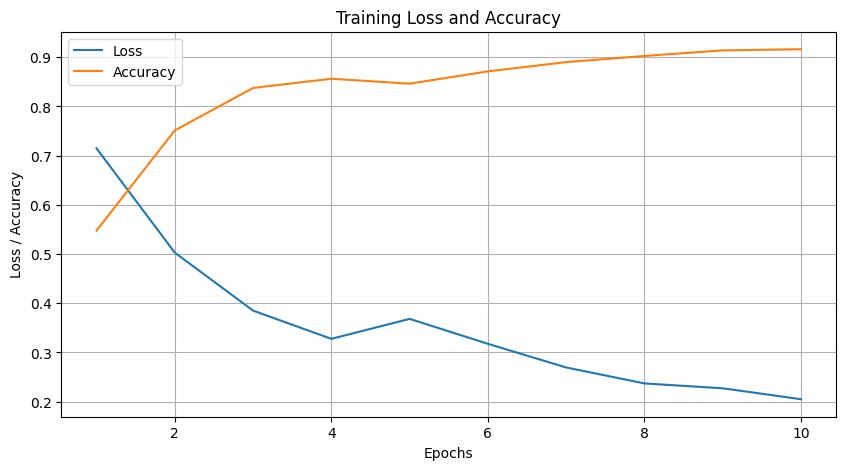

In [31]:
# 假設你的數據如下所示
epochs = range(1, 11)  # 總 epoch 數為 10
loss = [0.7148, 0.5028, 0.3850, 0.3276, 0.3682, 0.3175, 0.2694, 0.2370, 0.2271, 0.2049]  # loss 數據列表
accuracy = [0.5475, 0.7512, 0.8375, 0.8562, 0.8462, 0.8712, 0.8900, 0.9025, 0.9138, 0.9162]  # accuracy 數據列表

# 繪製 loss 和 accuracy 的折線圖
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, label='Loss')
plt.plot(epochs, accuracy, label='Accuracy')
plt.title('Training Loss and Accuracy curve')
plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.grid(True)
plt.show()

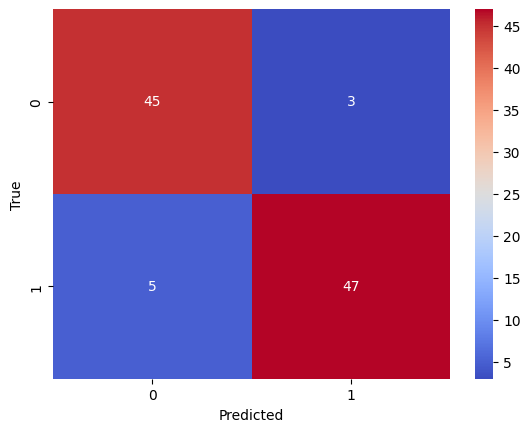

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 定義 array
array = np.array([[45, 3], [5, 47]])

# 使用 Seaborn 繪製 heatmap
sns.heatmap(array, annot=True, cmap='coolwarm', fmt='d')

# 設定 x 軸和 y 軸標籤
plt.xlabel('Predicted')
plt.ylabel('True')

# 顯示圖形
plt.show()
